## NPM3D - Point Transfomer 3D

In the context of the project, I decided to focus on the implementation of one part of the paper: **the ModelNet40 classification task**.

To help me implement this architecture and give me the necessary intuition, I was inspired by the content of this github : 

https://github.com/qq456cvb/Point-Transformers

# Imports and project setup

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import random
import pickle

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms

from tqdm import tqdm

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Load Dataset

## ModelNet from stanford edu

In [ ]:
!wget --no-check-certificate -P data/ https://shapenet.cs.stanford.edu/media/modelnet40_normal_resampled.zip

--2023-03-11 06:44:22--  https://shapenet.cs.stanford.edu/media/modelnet40_normal_resampled.zip
Resolving shapenet.cs.stanford.edu (shapenet.cs.stanford.edu)... 171.67.77.19
Connecting to shapenet.cs.stanford.edu (shapenet.cs.stanford.edu)|171.67.77.19|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 1705117335 (1.6G) [application/zip]
Saving to: ‘data/modelnet40_normal_resampled.zip’

modelnet40_normal_r 100%[===================>]   1.59G  40.2MB/s    in 42s     

2023-03-11 06:45:05 (38.3 MB/s) - ‘data/modelnet40_normal_resampled.zip’ saved [1705117335/1705117335]



In [ ]:
!unzip -q -o -d data/ data/modelnet40_normal_resampled.zip

# DataLoader

Definition of a data loader

In [ ]:
def pc_normalize(pc):
    centroid = np.mean(pc, axis=0)
    pc = pc - centroid
    m = np.max(np.sqrt(np.sum(pc**2, axis=1)))
    pc = pc / m
    return pc


#divide the points into local groups and several set 
def farthest_point_sample(point, npoint):
    """
    Input:
        xyz: pointcloud data, [N, D]
        npoint: number of samples
    Return:
        centroids: sampled pointcloud index, [npoint, D]
    """
    N, D = point.shape
    xyz = point[:,:3]
    centroids = np.zeros((npoint,))
    distance = np.ones((N,)) * 1e10
    farthest = np.random.randint(0, N)
    for i in range(npoint):
        centroids[i] = farthest
        centroid = xyz[farthest, :]
        dist = np.sum((xyz - centroid) ** 2, -1)
        mask = dist < distance
        distance[mask] = dist[mask]
        farthest = np.argmax(distance, -1)
    point = point[centroids.astype(np.int32)]
    return point


#random and shuffle tasks
class RandomRotation_z(object):
    def __call__(self, pointcloud):
        theta = random.random() * 2. * np.pi
        rot_matrix = np.array([[ np.cos(theta), -np.sin(theta),      0],
                               [ np.sin(theta),  np.cos(theta),      0],
                               [0,                               0,      1]])
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return rot_pointcloud

class RandomNoise(object):
    def __call__(self, pointcloud):
        noise = np.random.normal(0, 0.02, (pointcloud.shape))
        noisy_pointcloud = pointcloud + noise
        return noisy_pointcloud

class ShufflePoints(object):
    def __call__(self, pointcloud):
        np.random.shuffle(pointcloud)
        return pointcloud

def default_transforms():
    return transforms.Compose([RandomRotation_z(), RandomNoise()])


class ModelNetDataLoader(Dataset):
    def __init__(self, root, num_point=1024, transforms=default_transforms(), use_uniform_sample=True, use_normals=True, 
                 num_category=40, split='train', process_data=False):
        self.root = root
        self.npoints = num_point
        self.process_data = process_data
        self.uniform = use_uniform_sample
        self.use_normals = use_normals
        self.num_category = num_category
        self.transforms = transforms

        if self.num_category == 10:
            self.catfile = os.path.join(self.root, 'modelnet10_shape_names.txt')
        else:
            self.catfile = os.path.join(self.root, 'modelnet40_shape_names.txt')

        self.cat = [line.rstrip() for line in open(self.catfile)]
        self.classes = dict(zip(self.cat, range(len(self.cat))))

        shape_ids = {}
        if self.num_category == 10:
            shape_ids['train'] = [line.rstrip() for line in open(os.path.join(self.root, 'modelnet10_train.txt'))]
            shape_ids['test'] = [line.rstrip() for line in open(os.path.join(self.root, 'modelnet10_test.txt'))]
        else:
            shape_ids['train'] = [line.rstrip() for line in open(os.path.join(self.root, 'modelnet40_train.txt'))]
            shape_ids['test'] = [line.rstrip() for line in open(os.path.join(self.root, 'modelnet40_test.txt'))]

        assert (split == 'train' or split == 'test')
        shape_names = ['_'.join(x.split('_')[0:-1]) for x in shape_ids[split]]
        self.datapath = [(shape_names[i], os.path.join(self.root, shape_names[i], shape_ids[split][i]) + '.txt') for i
                         in range(len(shape_ids[split]))]
        print('The size of %s data is %d' % (split, len(self.datapath)))

        if self.uniform:
            self.save_path = os.path.join(root, 'modelnet%d_%s_%dpts_fps.dat' % (self.num_category, split, self.npoints))
        else:
            self.save_path = os.path.join(root, 'modelnet%d_%s_%dpts.dat' % (self.num_category, split, self.npoints))

        if self.process_data:
            if not os.path.exists(self.save_path):
                print('Processing data %s (only running in the first time)...' % self.save_path)
                self.list_of_points = [None] * len(self.datapath)
                self.list_of_labels = [None] * len(self.datapath)

                for index in tqdm(range(len(self.datapath)), total=len(self.datapath), position=0, leave=True):
                    fn = self.datapath[index]
                    cls = self.classes[self.datapath[index][0]]
                    cls = np.array([cls]).astype(np.int32)
                    point_set = np.loadtxt(fn[1], delimiter=',').astype(np.float32)

                    if self.uniform:
                        point_set = farthest_point_sample(point_set, self.npoints)
                    else:
                        point_set = point_set[0:self.npoints, :]

                    self.list_of_points[index] = point_set
                    self.list_of_labels[index] = cls

                with open(self.save_path, 'wb') as f:
                    pickle.dump([self.list_of_points, self.list_of_labels], f)
            else:
                print('Load processed data from %s...' % self.save_path)
                with open(self.save_path, 'rb') as f:
                    self.list_of_points, self.list_of_labels = pickle.load(f)

    def __len__(self):
        return len(self.datapath)

    def _get_item(self, index):
        if self.process_data:
            point_set, label = self.list_of_points[index], self.list_of_labels[index]
            point_set[:, 0:3] = pc_normalize(point_set[:, 0:3])
        else:
            fn = self.datapath[index]
            cls = self.classes[self.datapath[index][0]]
            label = np.array([cls]).astype(np.int32)
            point_set = np.loadtxt(fn[1], delimiter=',').astype(np.float32)

            if self.uniform:
                point_set = farthest_point_sample(point_set, self.npoints)
            else:
                point_set = point_set[0:self.npoints, :]

        if not self.use_normals:
            point_set = point_set[:, 0:3]
        
        if self.transforms is not None:
            point_set[:, 0:3] = self.transforms(point_set[:, 0:3])

        return point_set, label[0]

    def __getitem__(self, index):
        return self._get_item(index)

In [ ]:
data = ModelNetDataLoader('data/modelnet40_normal_resampled/', 
                          split='test', 
                          process_data=True)
DataLoader = torch.utils.data.DataLoader(data, batch_size=4096, shuffle=True)
for point, label in DataLoader:
    print(point.shape)
    print(label.shape)

The size of test data is 2468
Processing data data/modelnet40_normal_resampled/modelnet40_test_1024pts_fps.dat (only running in the first time)...


100%|██████████| 2468/2468 [19:50<00:00,  2.07it/s]


torch.Size([2468, 1024, 6])
torch.Size([2468])


# Point Transformer

## Point Transformer Block

In [ ]:
def square_distance(src, dst): 
    """
    Input:
        src: source points, [B, N, C]
        dst: target points, [B, M, C]
    Output:
        dist: per-point square distance, [B, N, M]
    """
    return torch.sum((src[:, :, None] - dst[:, None]) ** 2, dim=-1)

def index_points(points, idx):
    """
    Input:
        points: input points data, [B, N, C]
        idx: sample index data, [B, S, K]
    Output:
        new_points:, indexed points data, [B, S, K, C]
    """
    raw_size = idx.size()
    idx = idx.reshape(raw_size[0], -1)
    res = torch.gather(points, 1, idx[..., None].expand(-1, -1, points.size(-1)))
    return res.reshape(*raw_size, -1)


#architecture transformer
class BlockPointTransformer(nn.Module):
    def __init__(self, d_points, d_model, k) -> None:
        super().__init__()
        self.fc1 = nn.Linear(d_points, d_model)
        self.fc2 = nn.Linear(d_model, d_points)
        self.fc_delta = nn.Sequential(
            nn.Linear(3, d_model),
            nn.ReLU(),
            nn.Linear(d_model, d_model)
        )
        self.fc_gamma = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, d_model)
        )
        self.phi = nn.Linear(d_model, d_model, bias=False) # queries
        self.psi = nn.Linear(d_model, d_model, bias=False) # keys
        self.alpha = nn.Linear(d_model, d_model, bias=False) # values
        self.k = k
        
    # xyz: b x n x 3, features: b x n x f (f=d_points)
    def forward(self, xyz, features):
        distance = square_distance(xyz, xyz)  # b x n x n
        knn_idx = distance.argsort()[:, :, :self.k]  # b x n x k
        knn_xyz = index_points(xyz, knn_idx) # b x n x k x 3
        
        pre = features # b x n x f
        x = self.fc1(features) # b x n x d_model

        q = self.phi(x) # b x n x d_model
        k = index_points(self.psi(x), knn_idx) 
        v = index_points(self.alpha(x), knn_idx) 

        pos_enc = self.fc_delta(xyz[:, :, None] - knn_xyz)  
        
        attention = self.fc_gamma(q[:, :, None] - k + pos_enc) 
        attention = F.softmax(attention / np.sqrt(k.size(-1)), dim=-2)  
        
        res = torch.einsum('bmnf,bmnf->bmf', attention, v + pos_enc) 
        res = self.fc2(res) + pre # b x n x f
        return res, attention

## Transition down & Transition up

In [ ]:
#greedy algorithm that samples from a point cloud data iteratively by batch
def farthest_point_sample_batch(xyz, npoint):
    """
        xyz: pointcloud data, [B, N, 3]
        npoint: number of samples
        centroids output : sampled pointcloud index, [B, npoint]
    """
    device = xyz.device
    B, N, C = xyz.shape
    centroids = torch.zeros(B, npoint, dtype=torch.long).to(device)
    distance = torch.ones(B, N).to(device) * 1e10
    farthest = torch.randint(0, N, (B,), dtype=torch.long).to(device)
    batch_indices = torch.arange(B, dtype=torch.long).to(device)
    for i in range(npoint):
        centroids[:, i] = farthest
        centroid = xyz[batch_indices, farthest, :].view(B, 1, 3)  
        dist = torch.sum((xyz - centroid) ** 2, -1)
        distance = torch.min(distance, dist)
        farthest = torch.max(distance, -1)[1]
    return centroids.to(device)

#reduce the cardinality of the point set
class TransitionDown(nn.Module):
    def __init__(self, npoint, k, input_dim, output_dim) -> None:
        """
        npoint: target number of points after transition down
        nneighbor: number of neighbors to max pool the new features from
        input_dim: dimension of input features for each point
        outut_dim: dimension of output features for each point
        """
        super().__init__()
        self.npoint = npoint
        self.k = k
      
        self.mlp_convs = nn.ModuleList([
            nn.Conv2d(input_dim, output_dim, 1),
            nn.Conv2d(output_dim, output_dim, 1)
        ])
        self.mlp_bns = nn.ModuleList([
            nn.BatchNorm2d(output_dim),
            nn.BatchNorm2d(output_dim)
        ])
        
    def forward(self, xyz, features):
        """
            xyz: input points position data, [B, N, 3]
            features: input points data, [B, N, D]
            new_xyz: sampled points position data, [B, S, 3]
            new_features: new points feature data, [B, S, D']
        """
        fps_idx = farthest_point_sample_batch(xyz, self.npoint) # B x npoint
        torch.cuda.empty_cache()
        new_xyz = index_points(xyz, fps_idx) # B x npoint x 3
        torch.cuda.empty_cache()
        dists = square_distance(new_xyz, xyz)  
        idx = dists.argsort()[:, :, :self.k]  
        torch.cuda.empty_cache()
        grouped_xyz = index_points(xyz, idx) # B x npoint x k x 3
        torch.cuda.empty_cache()

        B, N, D = features.shape

        new_features = index_points(features, idx) # B x npoint x k x D
        new_features = new_features.permute(0, 3, 2, 1) 
        for i, conv in enumerate(self.mlp_convs):
             bn = self.mlp_bns[i]
             new_features =  F.relu(bn(conv(new_features))) 
        new_features, _ = torch.max(new_features, 2) # B x D' x npoint
        new_features = new_features.transpose(1,2) # B x npoint x D'

        return new_xyz, new_features

# Config Experimentation

I tested differents :
- optimizer (SGD, Adam, RMSProp)
- epoch (100,200)
- nblocks
- transformer_dim (The dimension of the transformer D) : 32, 64, 128
- K neighbor : 4, 8, 32

In [ ]:
class Configuration:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

#parameters configuration
cfgn = Configuration(
    model = Configuration(nneighbor = 16, nblocks = 4, transformer_dim = 32),
    batch_size = 64,
    epoch = 200, #100
    learning_rate = 5e-3, #by default
    gpu = 1,
    num_point = 1024,
    optimizer = 'Adam', # SGD (original optimizer from paper) + RMSProp
    weight_decay = 1e-4,
    normal = True
)
cfgn.num_class = 40
cfgn.input_dim = 6 if cfgn.normal else 3

In [ ]:
#class Configuration:
#    def __init__(self, **kwargs):
#        self.__dict__.update(kwargs)
#
#parameters configuration
#cfgn = Config(
#    model = Configuration(nneighbor = 16, nblocks = 4, transformer_dim = 32),
#    batch_size = 64,
#    epoch = 200, #100
#    learning_rate = 5e-3, #by default
#    gpu = 1,
#    num_point = 1024,
#    optimizer = 'RMSprop', # SGD (original optimizer from paper)
#    weight_decay = 1e-4,
#    normal = True
#)
#cfgn.num_class = 40
#cfgn.input_dim = 6 if cfgn.normal else 3

# Architectures

## Point Transformer Architecture

In [ ]:
class Classif_PointTransformer(nn.Module):
    def __init__(self, cfgn) -> None:
        super().__init__()
        npoints, nblocks, nneighbor, n_c, d_points = cfgn.num_point, cfgn.model.nblocks, cfgn.model.nneighbor, cfgn.num_class, cfgn.input_dim
        self.fc1 = nn.Sequential(
            nn.Linear(d_points, 32),
            nn.ReLU(),
            nn.Linear(32, 32)
        )
        self.transformer1 = BlockPointTransformer(32, cfgn.model.transformer_dim, nneighbor)
        self.transition_downs = nn.ModuleList()
        self.transformers = nn.ModuleList()

        #for each block, update of the TD and the transformer architecture
        for i in range(nblocks):
            channel = 32 * 2 ** (i + 1)
            self.transition_downs.append(TransitionDown(npoints // 4 ** (i + 1), nneighbor, channel // 2, channel))
            self.transformers.append(BlockPointTransformer(channel, cfgn.model.transformer_dim, nneighbor))
            
        self.fc2 = nn.Sequential(
            nn.Linear(32 * 2 ** nblocks, 256), #128
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, n_c)
        )
        self.nblocks = nblocks
    
    def forward(self, x):
        xyz = x[..., :3]
        features = self.transformer1(xyz, self.fc1(x))[0]
        for i in range(self.nblocks):
            xyz, features = self.transition_downs[i](xyz, features)
            features = self.transformers[i](xyz, features)[0]
        res = self.fc2(features.mean(1))
        return res

# Shape Classification

In [ ]:
def train(model, device, cfgn, train_loader, test_loader=None, epochs=100, val_step=5):

    if epochs is None:
        epochs = cfgn.epoch

    criterion = nn.CrossEntropyLoss()

    #differents optimizer choices

    #Adam
    if cfgn.optimizer == 'Adam':
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=cfgn.learning_rate,
            betas=(0.9, 0.999),
            eps=1e-08,
            weight_decay=cfgn.weight_decay
        )
    
    #RMSProp
    elif cfgn.optimizer == 'RMSprop':
        optimizer = torch.optim.RMSprop(
            model.parameters(),
            lr=cfgn.learning_rate,
            eps=1e-08,
            weight_decay=cfgn.weight_decay
        )

    #SGD
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=cfgn.learning_rate, momentum=0.9, weight_decay=cfgn.weight_decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[epochs*6//10,epochs*8//10], gamma=0.1)
    
    val_accs = []
    train_accs = []
    best_val_acc = -1.0
    loss=0

    #iterations for each epoch
    for epoch in tqdm(range(epochs), position=0, leave=True): 
        model.train()
        correct = total = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.long()) #loss update
            loss.backward()
            optimizer.step()
            #optimizer.backward()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_acc = 100. * correct / total
        train_accs.append(train_acc)

        #train_acc = correct 
        #train_accs.append(train_acc)

        if (epoch+1) % val_step  == 0:
            model.eval()
            correct = total = 0
            if test_loader:
                with torch.no_grad():
                    for data in test_loader:
                        inputs, labels = data
                        inputs, labels = inputs.to(device), labels.to(device)
                        outputs = model(inputs)
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()
                val_acc = 100. * correct / total
                val_accs.append(val_acc)
                print('\n Epoch: %d, Train accuracy: %.1f %%, Test accuracy: %.1f %%' %(epoch+1, train_acc, val_acc))
            if val_accs[-1] > best_val_acc:
                torch.save(model.state_dict(), 'checkpoint.pth')
        else:
            print('\n Epoch: %d, Train accuracy: %.1f %%' %(epoch+1, train_acc))

        scheduler.step()

    return train_accs, val_accs

In [ ]:
model = Classif_PointTransformer(cfgn).to(device)
print(model)

Classif_PointTransformer(
  (fc1): Sequential(
    (0): Linear(in_features=6, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  )
  (transformer1): BlockPointTransformer(
    (fc1): Linear(in_features=32, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=32, bias=True)
    (fc_delta): Sequential(
      (0): Linear(in_features=3, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    )
    (fc_gamma): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    )
    (phi): Linear(in_features=32, out_features=32, bias=False)
    (psi): Linear(in_features=32, out_features=32, bias=False)
    (alpha): Linear(in_features=32, out_features=32, bias=False)
  )
  (transition_downs): ModuleList(
    (0): TransitionDown(
      (mlp_convs): ModuleList(
        (0): 

In [ ]:
#retrieve the test and train data
train_loader = torch.utils.data.DataLoader(
    ModelNetDataLoader('data/modelnet40_normal_resampled/', split='train', process_data=True, transforms=None), 
    batch_size=cfgn.batch_size, #by batch
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    ModelNetDataLoader('data/modelnet40_normal_resampled/', split='test', process_data=True, transforms=None), 
    batch_size=64, 
    shuffle=True
)

The size of train data is 9843
Processing data data/modelnet40_normal_resampled/modelnet40_train_1024pts_fps.dat (only running in the first time)...


100%|██████████| 9843/9843 [1:18:50<00:00,  2.08it/s]


The size of test data is 2468
Load processed data from data/modelnet40_normal_resampled/modelnet40_test_1024pts_fps.dat...


## Training launch

In [ ]:
train_accs, val_accs = train(model, device, cfgn, train_loader, test_loader, val_step=10, epochs=100)

torch.save(model.state_dict(), 'checkpoint_last.pth')
# download checkpoint file
files.download('checkpoint.pth')
files.download('checkpoint_last.pth')

  1%|          | 1/100 [00:49<1:22:06, 49.76s/it]


 Epoch: 1, Train accuracy: 44.0 %


  2%|▏         | 2/100 [01:33<1:15:22, 46.15s/it]


 Epoch: 2, Train accuracy: 62.7 %


  3%|▎         | 3/100 [02:15<1:11:42, 44.36s/it]


 Epoch: 3, Train accuracy: 68.6 %


  4%|▍         | 4/100 [02:57<1:09:27, 43.41s/it]


 Epoch: 4, Train accuracy: 73.6 %


  5%|▌         | 5/100 [03:39<1:07:59, 42.95s/it]


 Epoch: 5, Train accuracy: 75.5 %


  6%|▌         | 6/100 [04:21<1:06:46, 42.62s/it]


 Epoch: 6, Train accuracy: 77.9 %


  7%|▋         | 7/100 [05:03<1:05:44, 42.42s/it]


 Epoch: 7, Train accuracy: 80.1 %


  8%|▊         | 8/100 [05:45<1:04:39, 42.17s/it]


 Epoch: 8, Train accuracy: 81.1 %


  9%|▉         | 9/100 [06:27<1:03:49, 42.08s/it]


 Epoch: 9, Train accuracy: 81.8 %


 10%|█         | 10/100 [07:15<1:06:02, 44.02s/it]


 Epoch: 10, Train accuracy: 83.5 %, Test accuracy: 74.5 %


 11%|█         | 11/100 [07:57<1:04:11, 43.28s/it]


 Epoch: 11, Train accuracy: 84.4 %


 12%|█▏        | 12/100 [08:39<1:02:59, 42.95s/it]


 Epoch: 12, Train accuracy: 83.5 %


 13%|█▎        | 13/100 [09:21<1:01:55, 42.70s/it]


 Epoch: 13, Train accuracy: 84.3 %


 14%|█▍        | 14/100 [10:03<1:00:57, 42.52s/it]


 Epoch: 14, Train accuracy: 86.0 %


 15%|█▌        | 15/100 [10:45<1:00:02, 42.39s/it]


 Epoch: 15, Train accuracy: 85.9 %


 16%|█▌        | 16/100 [11:27<59:12, 42.29s/it]  


 Epoch: 16, Train accuracy: 86.5 %


 17%|█▋        | 17/100 [12:09<58:22, 42.20s/it]


 Epoch: 17, Train accuracy: 87.6 %


 18%|█▊        | 18/100 [12:51<57:33, 42.12s/it]


 Epoch: 18, Train accuracy: 87.1 %


 19%|█▉        | 19/100 [13:33<56:46, 42.05s/it]


 Epoch: 19, Train accuracy: 86.4 %


 20%|██        | 20/100 [14:21<58:37, 43.97s/it]


 Epoch: 20, Train accuracy: 87.1 %, Test accuracy: 77.9 %


 21%|██        | 21/100 [15:03<56:53, 43.20s/it]


 Epoch: 21, Train accuracy: 87.7 %


 22%|██▏       | 22/100 [15:45<55:41, 42.84s/it]


 Epoch: 22, Train accuracy: 88.9 %


 23%|██▎       | 23/100 [16:27<54:35, 42.54s/it]


 Epoch: 23, Train accuracy: 88.0 %


 24%|██▍       | 24/100 [17:09<53:39, 42.37s/it]


 Epoch: 24, Train accuracy: 89.1 %


 25%|██▌       | 25/100 [17:50<52:44, 42.20s/it]


 Epoch: 25, Train accuracy: 88.8 %


 26%|██▌       | 26/100 [18:32<51:55, 42.10s/it]


 Epoch: 26, Train accuracy: 88.5 %


 27%|██▋       | 27/100 [19:14<51:10, 42.07s/it]


 Epoch: 27, Train accuracy: 88.6 %


 28%|██▊       | 28/100 [19:56<50:27, 42.06s/it]


 Epoch: 28, Train accuracy: 88.3 %


 29%|██▉       | 29/100 [20:38<49:44, 42.03s/it]


 Epoch: 29, Train accuracy: 89.7 %


 30%|███       | 30/100 [21:27<51:24, 44.06s/it]


 Epoch: 30, Train accuracy: 89.7 %, Test accuracy: 82.5 %


 31%|███       | 31/100 [22:09<49:46, 43.28s/it]


 Epoch: 31, Train accuracy: 89.3 %


 32%|███▏      | 32/100 [22:51<48:36, 42.89s/it]


 Epoch: 32, Train accuracy: 89.5 %


 33%|███▎      | 33/100 [23:33<47:38, 42.66s/it]


 Epoch: 33, Train accuracy: 90.0 %


 34%|███▍      | 34/100 [24:14<46:37, 42.39s/it]


 Epoch: 34, Train accuracy: 90.4 %


 35%|███▌      | 35/100 [24:56<45:43, 42.21s/it]


 Epoch: 35, Train accuracy: 90.0 %


 36%|███▌      | 36/100 [25:38<44:51, 42.05s/it]


 Epoch: 36, Train accuracy: 89.9 %


 37%|███▋      | 37/100 [26:20<44:04, 41.97s/it]


 Epoch: 37, Train accuracy: 90.1 %


 38%|███▊      | 38/100 [27:02<43:18, 41.92s/it]


 Epoch: 38, Train accuracy: 90.9 %


 39%|███▉      | 39/100 [27:44<42:38, 41.94s/it]


 Epoch: 39, Train accuracy: 89.9 %


 40%|████      | 40/100 [28:32<43:56, 43.94s/it]


 Epoch: 40, Train accuracy: 89.7 %, Test accuracy: 77.3 %


 41%|████      | 41/100 [29:14<42:27, 43.17s/it]


 Epoch: 41, Train accuracy: 90.5 %


 42%|████▏     | 42/100 [29:55<41:19, 42.75s/it]


 Epoch: 42, Train accuracy: 90.5 %


 43%|████▎     | 43/100 [30:37<40:20, 42.46s/it]


 Epoch: 43, Train accuracy: 91.2 %


 44%|████▍     | 44/100 [31:19<39:29, 42.31s/it]


 Epoch: 44, Train accuracy: 91.8 %


 45%|████▌     | 45/100 [32:01<38:41, 42.20s/it]


 Epoch: 45, Train accuracy: 91.1 %


 46%|████▌     | 46/100 [32:43<37:53, 42.11s/it]


 Epoch: 46, Train accuracy: 90.6 %


 47%|████▋     | 47/100 [33:25<37:10, 42.08s/it]


 Epoch: 47, Train accuracy: 90.5 %


 48%|████▊     | 48/100 [34:07<36:23, 42.00s/it]


 Epoch: 48, Train accuracy: 90.7 %


 49%|████▉     | 49/100 [34:49<35:41, 41.99s/it]


 Epoch: 49, Train accuracy: 90.3 %


 50%|█████     | 50/100 [35:37<36:31, 43.84s/it]


 Epoch: 50, Train accuracy: 91.0 %, Test accuracy: 86.6 %


 51%|█████     | 51/100 [36:18<35:11, 43.08s/it]


 Epoch: 51, Train accuracy: 91.2 %


 52%|█████▏    | 52/100 [37:00<34:10, 42.71s/it]


 Epoch: 52, Train accuracy: 91.4 %


 53%|█████▎    | 53/100 [37:42<33:16, 42.47s/it]


 Epoch: 53, Train accuracy: 91.7 %


 54%|█████▍    | 54/100 [38:24<32:25, 42.29s/it]


 Epoch: 54, Train accuracy: 91.7 %


 55%|█████▌    | 55/100 [39:06<31:38, 42.18s/it]


 Epoch: 55, Train accuracy: 92.6 %


 56%|█████▌    | 56/100 [39:48<30:51, 42.09s/it]


 Epoch: 56, Train accuracy: 91.6 %


 57%|█████▋    | 57/100 [40:29<30:05, 41.98s/it]


 Epoch: 57, Train accuracy: 91.1 %


 58%|█████▊    | 58/100 [41:11<29:20, 41.93s/it]


 Epoch: 58, Train accuracy: 90.1 %


 59%|█████▉    | 59/100 [41:53<28:39, 41.94s/it]


 Epoch: 59, Train accuracy: 91.1 %


 60%|██████    | 60/100 [42:42<29:16, 43.91s/it]


 Epoch: 60, Train accuracy: 91.7 %, Test accuracy: 83.4 %


 61%|██████    | 61/100 [43:23<28:00, 43.10s/it]


 Epoch: 61, Train accuracy: 94.5 %


 62%|██████▏   | 62/100 [44:05<27:02, 42.69s/it]


 Epoch: 62, Train accuracy: 95.3 %


 63%|██████▎   | 63/100 [44:46<26:09, 42.42s/it]


 Epoch: 63, Train accuracy: 95.7 %


 64%|██████▍   | 64/100 [45:28<25:23, 42.31s/it]


 Epoch: 64, Train accuracy: 95.7 %


 65%|██████▌   | 65/100 [46:10<24:35, 42.15s/it]


 Epoch: 65, Train accuracy: 95.9 %


 66%|██████▌   | 66/100 [46:52<23:50, 42.07s/it]


 Epoch: 66, Train accuracy: 96.2 %


 67%|██████▋   | 67/100 [47:34<23:06, 42.03s/it]


 Epoch: 67, Train accuracy: 96.0 %


 68%|██████▊   | 68/100 [48:16<22:24, 42.01s/it]


 Epoch: 68, Train accuracy: 96.3 %


 69%|██████▉   | 69/100 [48:58<21:40, 41.96s/it]


 Epoch: 69, Train accuracy: 96.3 %


 70%|███████   | 70/100 [49:46<21:56, 43.88s/it]


 Epoch: 70, Train accuracy: 96.2 %, Test accuracy: 89.6 %


 71%|███████   | 71/100 [50:28<20:51, 43.15s/it]


 Epoch: 71, Train accuracy: 96.3 %


 72%|███████▏  | 72/100 [51:10<19:58, 42.80s/it]


 Epoch: 72, Train accuracy: 96.5 %


 73%|███████▎  | 73/100 [51:51<19:07, 42.50s/it]


 Epoch: 73, Train accuracy: 96.7 %


 74%|███████▍  | 74/100 [52:33<18:19, 42.28s/it]


 Epoch: 74, Train accuracy: 96.6 %


 75%|███████▌  | 75/100 [53:15<17:32, 42.12s/it]


 Epoch: 75, Train accuracy: 97.0 %


 76%|███████▌  | 76/100 [53:57<16:49, 42.08s/it]


 Epoch: 76, Train accuracy: 96.8 %


 77%|███████▋  | 77/100 [54:39<16:06, 42.01s/it]


 Epoch: 77, Train accuracy: 96.8 %


 78%|███████▊  | 78/100 [55:21<15:23, 41.97s/it]


 Epoch: 78, Train accuracy: 96.9 %


 79%|███████▉  | 79/100 [56:02<14:39, 41.89s/it]


 Epoch: 79, Train accuracy: 97.0 %


 80%|████████  | 80/100 [56:51<14:36, 43.84s/it]


 Epoch: 80, Train accuracy: 96.8 %, Test accuracy: 89.4 %


 81%|████████  | 81/100 [57:32<13:38, 43.09s/it]


 Epoch: 81, Train accuracy: 97.3 %


 82%|████████▏ | 82/100 [58:14<12:48, 42.69s/it]


 Epoch: 82, Train accuracy: 97.2 %


 83%|████████▎ | 83/100 [58:56<12:01, 42.44s/it]


 Epoch: 83, Train accuracy: 97.4 %


 84%|████████▍ | 84/100 [59:38<11:16, 42.30s/it]


 Epoch: 84, Train accuracy: 97.5 %


 85%|████████▌ | 85/100 [1:00:19<10:31, 42.12s/it]


 Epoch: 85, Train accuracy: 97.6 %


 86%|████████▌ | 86/100 [1:01:01<09:48, 42.00s/it]


 Epoch: 86, Train accuracy: 97.4 %


 87%|████████▋ | 87/100 [1:01:43<09:05, 41.95s/it]


 Epoch: 87, Train accuracy: 97.4 %


 88%|████████▊ | 88/100 [1:02:25<08:23, 41.93s/it]


 Epoch: 88, Train accuracy: 97.3 %


 89%|████████▉ | 89/100 [1:03:07<07:40, 41.90s/it]


 Epoch: 89, Train accuracy: 97.6 %


 90%|█████████ | 90/100 [1:03:55<07:18, 43.81s/it]


 Epoch: 90, Train accuracy: 97.6 %, Test accuracy: 89.6 %


 91%|█████████ | 91/100 [1:04:35<06:23, 42.66s/it]


 Epoch: 91, Train accuracy: 97.7 %


In [ ]:
#train_accs, val_accs = train(model, device, cfgn, train_loader, test_loader, val_step=10, epochs=100)
#torch.save(model.state_dict(), 'checkpoint_last.pth')
# download checkpoint file
#files.download('checkpoint.pth')
#files.download('checkpoint_last.pth')

In [ ]:
pickle.dump([train_accs, val_accs], open('accs_200epoch_transdim128.p', 'wb'))

In [ ]:
#pickle.dump([train_accs, val_accs], open('accs_100epoch_transdim128.p', 'wb'))

In [ ]:
files.download('accs_200epoch_transdim128.p')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#files.download('accs_100epoch_transdim128.p')

## Optimizer experimentation

## SGD

Text(0.5, 1.0, 'Max accuracy on the test')

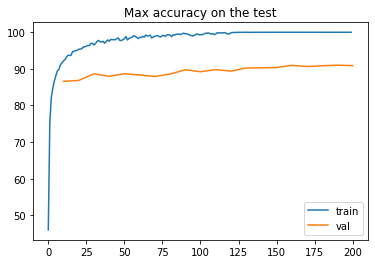

In [ ]:
plt.plot(train_accs, label="train")
plt.plot([10*i for i in range(1,21)],val_accs,label="val")
plt.legend()
plt.title("Max accuracy on the test")

## Adam

In [ ]:
plt.plot(train_accs, label="train")
plt.plot([10*i for i in range(1,21)],val_accs,label="val")
plt.legend()
plt.title("Max accuracy on the test")

## RMSProp

Text(0.5, 1.0, 'Max accuracy on the test')

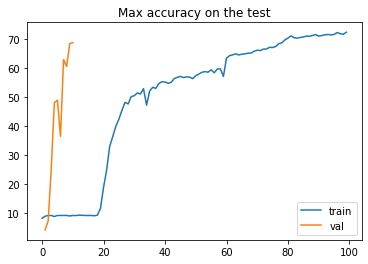

In [ ]:
plt.plot(train_accs, label="train")
plt.plot([i for i in range(1,11)],val_accs,label="val")
plt.legend()
plt.title("Max accuracy on the test")

## Dimension Transformer experimentation

D = 32

In [ ]:
plt.plot(train_accs, label="train")
plt.plot([10*i for i in range(1,21)],val_accs,label="val")
plt.legend()
plt.title("Max accuracy on the test")

In [ ]:
#plt.plot(train_accs, label="train")
#plt.plot([10*i for i in range(1,21)],val_accs,label="val")
#plt.legend()
#plt.title("Max accuracy on the test")